In [ ]:
#input尝试三种，一个是mfcc图像，一个是vggish输出的特征值，还有一个是opensmile输出的特征值

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd

# 定义函数来处理一个文件夹中的音频文件并返回DataFrame
def process_audio_folder(data_dir, categories):
    features = []
    labels = []
    ids = []

    for category in categories:
        category_path = os.path.join(data_dir, category)
        label = categories.index(category)

        for filename in os.listdir(category_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(category_path, filename)

                # 解析出编号（假设文件名格式为 '163_male_breathe.wav'）
                file_id = filename.split('_')[0]

                # 读取音频文件
                y, sr = librosa.load(file_path, sr=None)

                # 提取MFCC特征
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                mfccs_mean = np.mean(mfccs.T, axis=0)

                # 将特征、标签和编号存入列表
                features.append(mfccs_mean)
                labels.append(label)
                ids.append(file_id)

    # 创建DataFrame并将id设置为索引
    df = pd.DataFrame(features)
    df['label'] = labels
    df['id'] = ids
    df.set_index('id', inplace=True)

    return df

# 定义文件夹路径和类别
folders = ['breathing', 'cough', 'read']
categories = ['negative', 'positive']

# 处理每个文件夹并生成相应的DataFrame
dfs = {}
for folder in folders:
    folder_path = os.path.join('训练集', folder)
    df = process_audio_folder(folder_path, categories)
    dfs[folder] = df
    df.to_csv(f'covid_{folder}_mfcc_features_with_ids.csv')

# dfs字典包含三个DataFrame，分别对应breathing, cough, 和count文件夹


In [ ]:
df

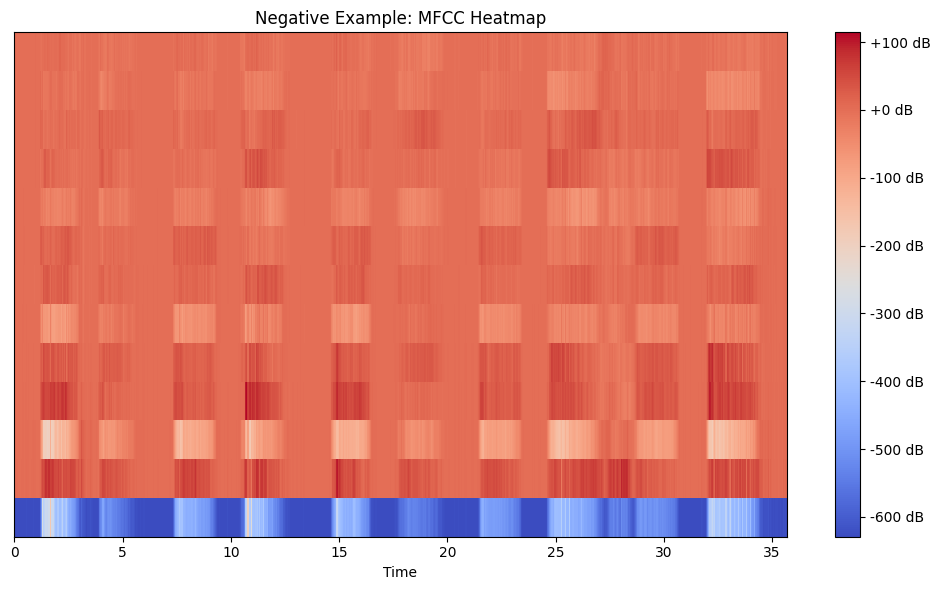

In [2]:
import matplotlib.pyplot as plt
import librosa.display

def plot_mfcc_heatmap(y, sr, title="MFCC"):
    # 提取MFCC特征
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    # 可视化MFCC特征的热图
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 示例：从一个音频文件中提取并可视化MFCC热图
y, sr = librosa.load('训练集/breathing/negative/163_male_breathe.wav', sr=None)
plot_mfcc_heatmap(y, sr, title="Negative Example: MFCC Heatmap")


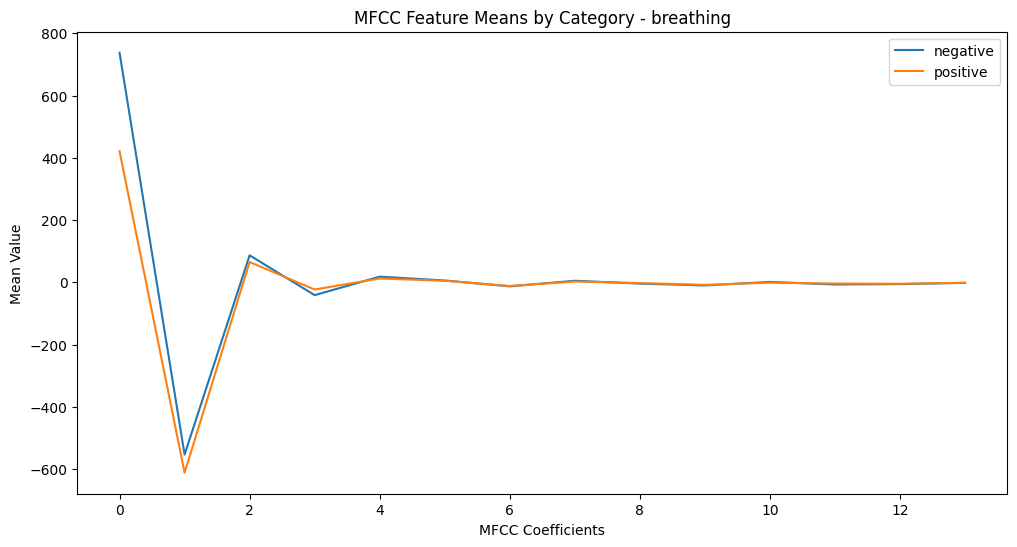

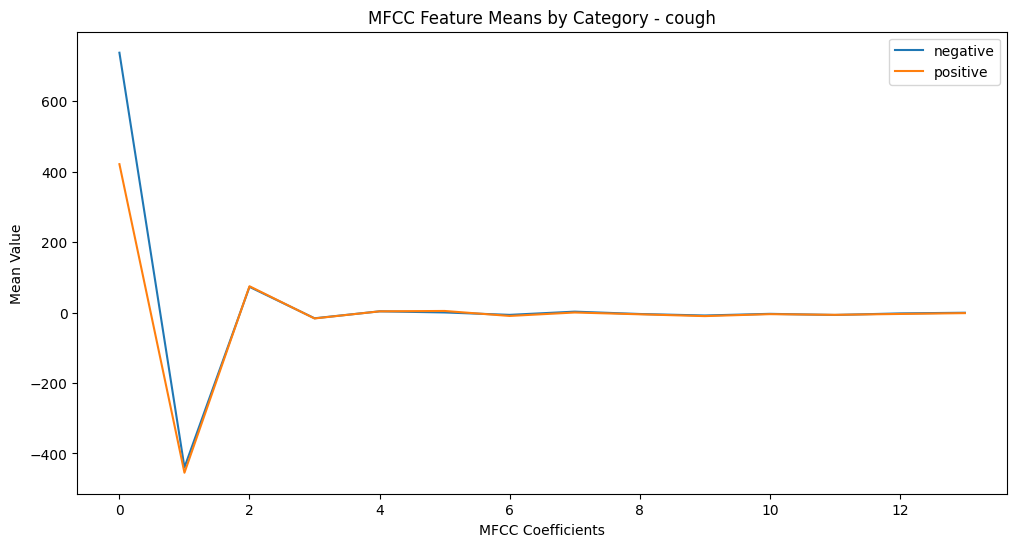

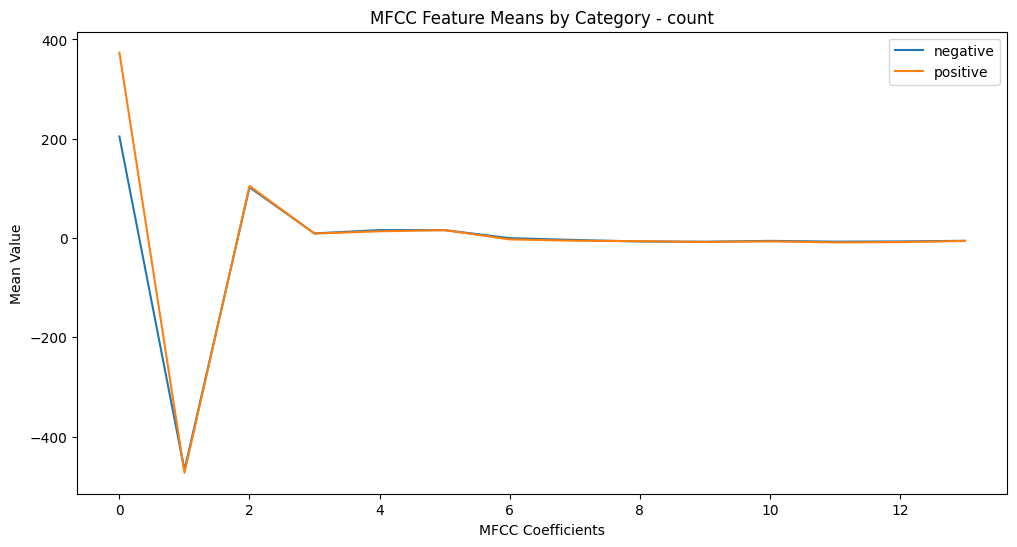

In [3]:
# 定义绘制MFCC特征平均值曲线的函数
def plot_mfcc_distribution(df, category_names, title_suffix):
    features = df.iloc[:, :-1].values
    labels = df['label'].values
    
    plt.figure(figsize=(12, 6))
    
    for i, category_name in enumerate(category_names):
        category_features = features[labels == i]
        mfcc_mean = np.mean(category_features, axis=0)
        
        plt.plot(mfcc_mean, label=category_name)
    
    plt.title(f'MFCC Feature Means by Category - {title_suffix}')
    plt.xlabel('MFCC Coefficients')
    plt.ylabel('Mean Value')
    plt.legend()
    plt.show()
#对每个类别的MFCC特征求平均值，并绘制各个MFCC系数的平均值曲线，以比较不同类别之间的差异。
# 定义要处理的文件和类别
folders = ['breathing', 'cough', 'read']
categories = ['negative', 'positive']

# 读取每个文件夹的CSV文件并绘制图像
for folder in folders:
    # 读取CSV文件
    df = pd.read_csv(f'covid_{folder}_mfcc_features_with_ids.csv')
    
    # 绘制图像
    plot_mfcc_distribution(df, categories, folder)


In [ ]:
import os
import librosa
import matplotlib.pyplot as plt
import librosa.display

# 定义函数来提取MFCC特征并保存为图像
def save_mfcc_as_image(file_path, output_dir, n_mfcc=13):
    # 读取音频文件
    y, sr = librosa.load(file_path, sr=None)
    
    # 提取MFCC特征
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    # 创建图像文件路径
    file_name = os.path.basename(file_path).replace('.wav', '.png')
    output_file_path = os.path.join(output_dir, file_name)
    
    # 绘制MFCC特征并保存为图像
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.tight_layout()
    plt.savefig(output_file_path)
    plt.close()

# 示例：将一个文件夹中的所有音频文件的MFCC保存为图像
def process_folder_and_save_images(input_dir, output_dir, n_mfcc=13):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for filename in os.listdir(input_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(input_dir, filename)
            save_mfcc_as_image(file_path, output_dir, n_mfcc)

# 定义要处理的文件夹和类别
folders = ['breathing', 'cough', 'count']
categories = ['negative', 'positive']

# 遍历每个文件夹和类别，处理并保存MFCC图像
for folder in folders:
    for category in categories:
        input_folder = os.path.join('训练集', folder, category)
        output_folder = os.path.join('训练集', 'mfcc_images', folder, category)
        process_folder_and_save_images(input_folder, output_folder)



In [ ]:
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# 定义图像转换，包括调整图像尺寸和归一化
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图像尺寸为224x224，这是VGG19的标准输入尺寸
    transforms.ToTensor(),          # 转换为Tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # 归一化
])

# 加载呼吸数据集
breathing_dataset = datasets.ImageFolder(root='训练集/mfcc_images/breathing', transform=transform)

# 划分训练集和测试集（按80/20比例）
train_size = int(0.8 * len(breathing_dataset))
test_size = len(breathing_dataset) - train_size
train_dataset, test_dataset = random_split(breathing_dataset, [train_size, test_size])

# 创建DataLoader
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# 获取数据集大小
train_data_size = len(train_dataset)
test_data_size = len(test_dataset)

# 加载预训练的VGG19模型并修改分类层
net = models.vgg19(pretrained=True)
net.classifier[6] = nn.Linear(4096, 2)  # 修改为2分类
net = net.cuda()

# 定义损失函数和优化器
loss_cls = nn.CrossEntropyLoss().cuda()
learning_rate = 5e-4
optim = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.001)

# 设置训练参数
total_train_step = 0
total_test_step = 0
epoch = 100
max_cur = 0

# 开始训练
for i in range(epoch):
    print(f'----------第{i + 1}轮训练开始----------')

    # 训练步骤开始
    net.train()
    for data in train_dataloader:
        inputs, targets = data
        inputs, targets = inputs.cuda(), targets.cuda()

        output = net(inputs)
        loss = loss_cls(output, targets)

        # 优化器优化模型
        optim.zero_grad()
        loss.backward()
        optim.step()

        total_train_step += 1
        print(f'训练次数：{total_train_step}，loss：{loss.item()}')

    # 测试步骤开始
    net.eval()
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        print('----------测试开始----------')
        for data in test_dataloader:
            inputs, targets = data
            inputs, targets = inputs.cuda(), targets.cuda()

            output = net(inputs)
            loss = loss_cls(output, targets)
            total_test_loss += loss.item()

            _, pred = torch.max(output, dim=1)
            accuracy = (pred == targets).sum().item()
            total_accuracy += accuracy

    print(f'整体测试的loss为{total_test_loss}, 准确率为{total_accuracy / test_data_size:.4f}')
    acc_cur = total_accuracy / test_data_size

    # 保存最佳模型
    if acc_cur > max_cur:
        max_cur = acc_cur
        print("save model")
        torch.save(net.state_dict(), "best_model.pth")
